# Determining the Fisher information for trained networks.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import numpy as np
import torch

import pandas as pd
import polars as pl
import seaborn as sns

import plotly.express as px

## Model summary

In [2]:
# load the trained model
from datageneration.stimulusGeneration import generateGrating
from basicModel import EstimateAngle

from experiments.ex2_sensitivity_scaling import dataFile_Experiment2

# training data parameters
pixelDim = 101
shotNoise = 0.8
noiseVar = 20

# training data distribution
dataSize = 512
kappa_tr = 4.
loc_tr = 0.
rep = 0


fileName = dataFile_Experiment2(dataSize, kappa_tr, loc_tr, rep)
trained_model = EstimateAngle.load_from_checkpoint(fileName)

In [4]:
image = generateGrating([0.], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)

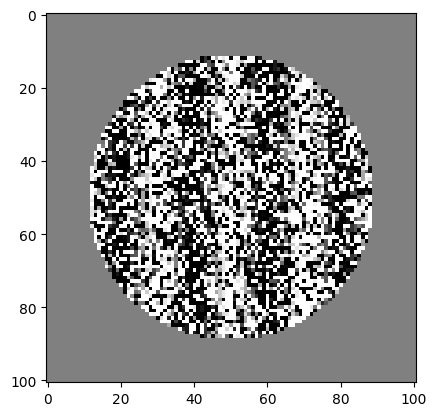

In [5]:
plt.imshow(image[0], cmap='gray')

In [6]:
trained_model.forward( image)

tensor([[114.8539,  -0.2635]], grad_fn=<AddmmBackward0>)

## Model sensitivity

### Output covariance

#### How much do the output covariances matrices vary between samples?

In [6]:
covs = []
for i in range(20):
    images = generateGrating(500*[0.], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)
    outputs = trained_model.forward(images)

    covs.append(outputs.T.cov().detach().numpy())

In [7]:
np.mean(covs, axis=0)

array([[71.78923 ,  3.486478],
       [ 3.486478,  8.274242]], dtype=float32)

In [8]:
np.var(covs, axis=0)

array([[17.543304  ,  1.3671246 ],
       [ 1.3671246 ,  0.21823172]], dtype=float32)

#### Variance between angles?
Compare this to other angular inputs

In [9]:
covs = []
for i in range(20):
    images = generateGrating(500*[0.1], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)
    outputs = trained_model.forward(images)

    covs.append(outputs.T.cov().detach().numpy())

In [10]:
np.mean(covs, axis=0)

array([[74.84468 , 12.998423],
       [12.998423, 10.735367]], dtype=float32)

In [11]:
np.var(covs, axis=0)

array([[19.493345 ,  1.4458009],
       [ 1.4458009,  0.6321355]], dtype=float32)

Here, we can see that, while the covariance looks similar between close angles, it does, in fact, change significantly.

In [12]:
covs = []
for i in range(20):
    images = generateGrating(500*[np.pi/4], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)
    outputs = trained_model.forward(images)

    covs.append(outputs.T.cov().detach().numpy())

In [13]:
np.mean(covs, axis=0)

array([[10.1988735,  1.0234685],
       [ 1.0234685, 81.55022  ]], dtype=float32)

Here the pattern is reversed between the variance of the two neurons.

### Visualization

In [7]:
xs = []
ys = []
angles = []

N=100
for angle in np.linspace(0, np.pi, 20):
    images = generateGrating(N*[angle], pixelDim=pixelDim,
                             shotNoise=shotNoise, noiseVar=noiseVar)
    outputs = trained_model.forward(images).detach().numpy()
    xs.extend(outputs[:,0])
    ys.extend(outputs[:,1])

    angles.extend(N*[angle])

samples = pd.DataFrame( {'x': xs, 'y': ys, 'input_angle': angles})


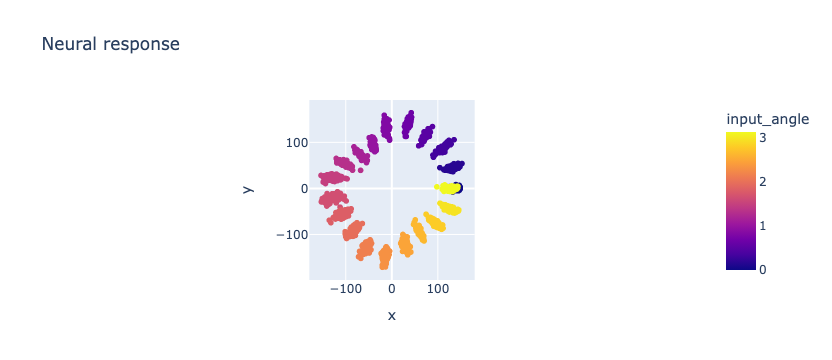

In [9]:
fig1 = px.scatter(samples, x='x', y='y', color='input_angle', title='Neural response')

fig1.update_xaxes(
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig1.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


This is a nice way to visualize both the changes in mean and the changes in variance with the stimulus. Note that the neural encodings change at a rate twice the changes in the input angle.

In [10]:
from discriminationAnalysis import sensitivityIndex

thetas = np.linspace(0, np.pi, 20)
sensitivity = []

for angle in thetas:
     sensitivity.append( sensitivityIndex( trained_model, angle))

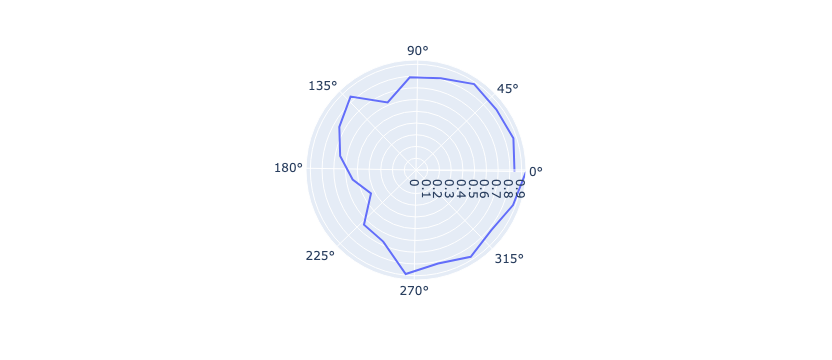

In [11]:
px.line_polar( theta=(360/(np.pi))*thetas, r=sensitivity, direction="counterclockwise")

Comparing our previous sensitivity metric to the neural traces, they line up quite well. Interestingly, the early fall off (near 90 deg in the plots) seems to result from differences in the mean behavior, while low performance near 225deg may result from the width of the distributions.

Nice to note is also the way that the large components of variation seem to project orthogonally to the direction of changes with angular inputs.

## Quantification:


#### Generally, I think that a multivariate gaussian process is the way to go here.

But, I'm not going to spend too much time on that for the moment.

In [258]:
pixelDim = 101
shotNoise = 0.8
noiseVar = 20

def approximateFisher(model, angle, N=1000):
    centered = model.forward(generateGrating(N*[angle], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)
                            ).detach().numpy()
    bigger = model.forward(generateGrating(N*[angle+0.05], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)
                          ).detach().numpy()
    smaller = model.forward(generateGrating(N*[angle-0.05], pixelDim=pixelDim, shotNoise=shotNoise, noiseVar=noiseVar)
                           ).detach().numpy()

    covMat = np.cov(centered.T)
    tuningDeriv = (bigger.mean(0) - smaller.mean(0)) / 0.1

    fisher = tuningDeriv @ np.linalg.inv(covMat) @ tuningDeriv

    N_neurons = tuningDeriv.shape[0]
    bcFisher = fisher * (2*N - N_neurons -3)/(2*N -3) - 2*N_neurons / (N*0.1**2)

    print(angle)
    return bcFisher


In [91]:
angles = np.linspace(0, np.pi, 100)

fisher = map( lambda x: approximateFisher(trained_model, x, N=2000), angles)

In [92]:
results = np.fromiter(fisher, float)

0.0
0.03173325912716963
0.06346651825433926
0.0951997773815089
0.12693303650867852
0.15866629563584814
0.1903995547630178
0.2221328138901874
0.25386607301735703
0.28559933214452665
0.3173325912716963
0.3490658503988659
0.3807991095260356
0.4125323686532052
0.4442656277803748
0.47599888690754444
0.5077321460347141
0.5394654051618837
0.5711986642890533
0.6029319234162229
0.6346651825433925
0.6663984416705622
0.6981317007977318
0.7298649599249014
0.7615982190520711
0.7933314781792408
0.8250647373064104
0.85679799643358
0.8885312555607496
0.9202645146879193
0.9519977738150889
0.9837310329422585
1.0154642920694281
1.0471975511965979
1.0789308103237674
1.110664069450937
1.1423973285781066
1.1741305877052763
1.2058638468324459
1.2375971059596156
1.269330365086785
1.3010636242139548
1.3327968833411243
1.364530142468294
1.3962634015954636
1.4279966607226333
1.4597299198498028
1.4914631789769726
1.5231964381041423
1.5549296972313118
1.5866629563584815
1.618396215485651
1.6501294746128208
1.68186

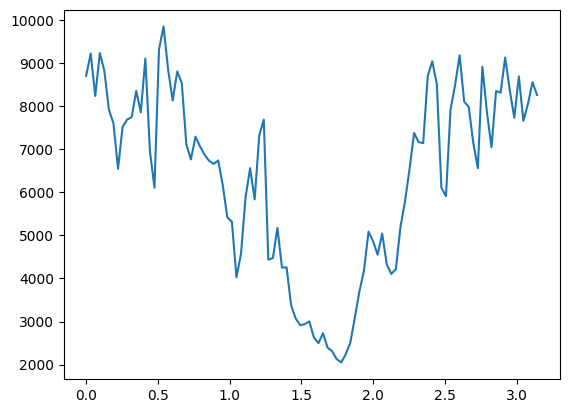

In [93]:
plt.plot(angles, results)

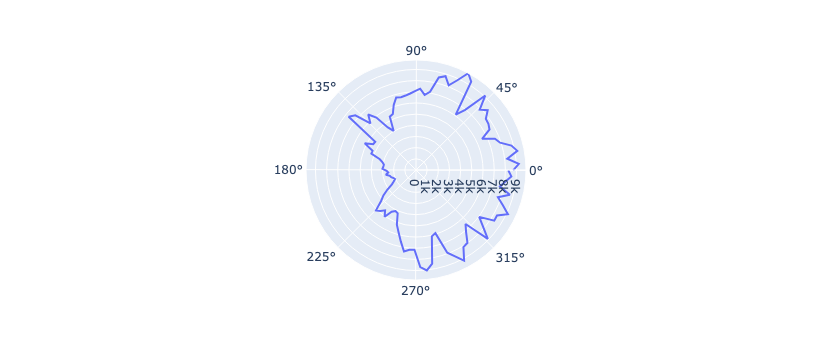

In [96]:
px.line_polar( theta=360/np.pi*angles, r=results, direction="counterclockwise")

In [99]:
replicates = [approximateFisher(trained_model, 0.) for i in range(20)]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


(array([1., 4., 2., 3., 3., 2., 3., 1., 0., 1.]),
 array([7921.83288239, 8129.03729712, 8336.24171184, 8543.44612656,
        8750.65054129, 8957.85495601, 9165.05937074, 9372.26378546,
        9579.46820018, 9786.67261491, 9993.87702963]),
 <BarContainer object of 10 artists>)

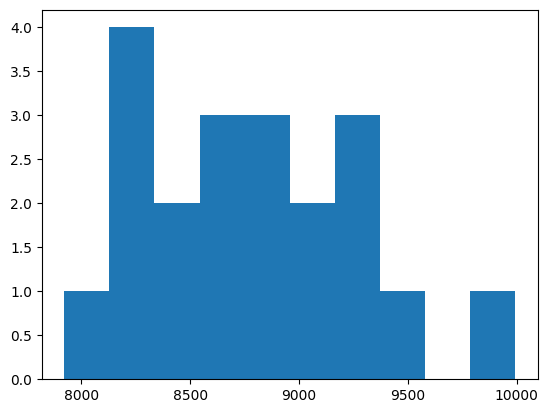

In [100]:
plt.hist(replicates)

These Fisher information fits seem _very_ noisy. Is there a way to improve these estimations?

It's worth doing more research into the literature.

## Where is the noise from?

Is it the variance estimates or the derivative estimates that are noisy?

### mean changes

!! error warning: these derivatice results are off by a factor of 2

In [12]:
def sample_mean_diff(angle=0., N=1000, diff=0.05, reps=50, track=True):
    samples = []
    for i in range(reps):
        bigger = trained_model.forward(generateGrating(N*[angle+diff], pixelDim=pixelDim,
                                                       shotNoise=shotNoise, noiseVar=noiseVar)
                                      ).detach().numpy()
        smaller = trained_model.forward(generateGrating(N*[angle-diff], pixelDim=pixelDim,
                                                        shotNoise=shotNoise, noiseVar=noiseVar)
                                        ).detach().numpy()
        samples.append((bigger.mean(0) - smaller.mean(0))/diff )
        if track:
            print(i)
    
    return np.array(samples)
    

In [41]:
angle=0.
N=1000
diff=0.05
bigger = trained_model.forward(generateGrating(N*[angle+diff], pixelDim=pixelDim,
                               shotNoise=shotNoise, noiseVar=noiseVar)).detach().numpy()

smaller = trained_model.forward(generateGrating(N*[angle-diff], pixelDim=pixelDim,
                                shotNoise=shotNoise, noiseVar=noiseVar)).detach().numpy()


(bigger.mean(0) - smaller.mean(0) ) / diff

array([113.515015, 528.5546  ], dtype=float32)

In [13]:
mean_samples = sample_mean_diff()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [14]:
np.cov( mean_samples.T)

array([[68.60422171, -3.75012056],
       [-3.75012056,  7.33841124]])

In [15]:
(np.var(mean_samples,0) / mean_samples.mean()).sum()

0.2306677

In [16]:
def generate_mean_effects(Ns=[500, 1000, 2000], diffs=[0.1, 0.05, 0.01], track=True):
    results_mean = []
    results_cov = []
    results_N = []
    results_diff = []
    
    for N in Ns:
        for diff in diffs:
            sample_means = sample_mean_diff(N=N, diff=diff, track=False)

            results_mean.append( sample_means.mean(0) )
            results_cov.append( np.cov(sample_means.T) )
            results_N.append(N)
            results_diff.append(diff)

            if track:
                print(N, diff)

    return pd.DataFrame({'N': results_N, 'diff': results_diff, 'mean': results_mean, 'cov': results_cov})


    

In [17]:
outs = generate_mean_effects()

500 0.1
500 0.05
500 0.01
1000 0.1
1000 0.05
1000 0.01
2000 0.1
2000 0.05
2000 0.01


In [18]:
outs

,N,diff,mean,cov
0,500,0.10,"[74.92994, 533.9764]","[[28.539058067695702, -0.5849241133893319], [-..."
1,500,0.05,"[116.72976, 525.48413]","[[157.68778722106998, 2.6923231264994465], [2...."
2,500,0.01,"[157.23611, 521.1961]","[[2887.8678234180015, 159.40363472331393], [15..."
3,1000,0.10,"[73.71023, 533.8056]","[[16.259394238239672, -0.3801554643815117], [-..."
4,1000,0.05,"[118.25506, 527.4012]","[[59.445469854789174, 4.084693940668083], [4.0..."
5,1000,0.01,"[146.28436, 526.73016]","[[1605.8546796260514, 43.03170056509957], [43...."
6,2000,0.10,"[74.365105, 534.31525]","[[7.4730821163132175, -0.8217921140812794], [-..."
7,2000,0.05,"[118.41507, 526.59326]","[[20.53389725378923, -1.891754754347612], [-1...."
8,2000,0.01,"[156.81035, 523.4572]","[[701.9736640193328, 37.26575849452341], [37.2..."


#### observations

1. The variance of our derivative estimates get _worse_ with smaller differences in parameter
2. However, the size of our mean estimates is also changing with the the difference.



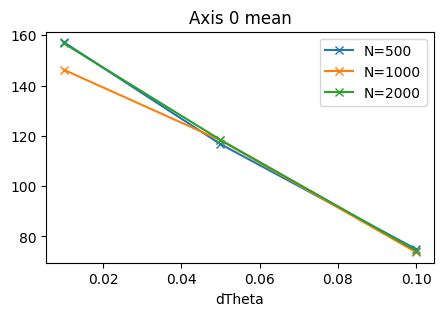

In [73]:
figsize(5,3)

for N in [500, 1000, 2000]:
    print(  )
    subset = outs[outs['N']==N]
    plt.plot(subset['diff'], list(map(lambda x: x[0], subset['mean'])), 'x-', label=f'N={N}')

plt.xlabel('dTheta')
_=plt.legend()
_=plt.title('Axis 0 mean')

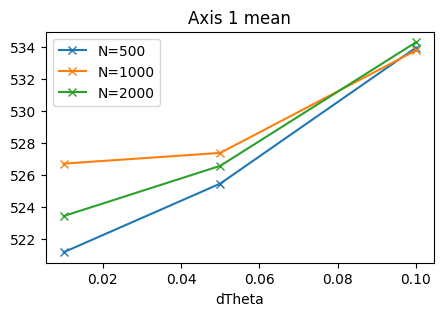

In [63]:
figsize(5,3)

for N in [500, 1000, 2000]:
    subset = outs[outs['N']==N]
    plt.plot(subset['diff'], list(map(lambda x: x[1], subset['mean'])), 'x-', label=f'N={N}')

plt.xlabel('dTheta')
_=plt.legend()
_=plt.title('Axis 1 mean')

Quite odd that the 1000 sample estimate seems the most different, but this could also be a reflection of the varaince. 

<ErrorbarContainer object of 3 artists>

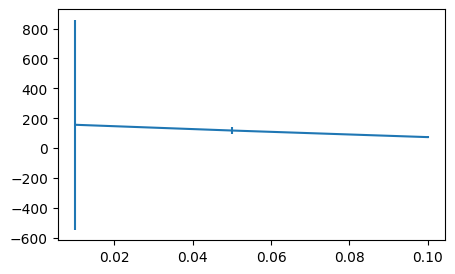

In [81]:
subset = outs[outs['N']== 2000]
plt.errorbar(subset['diff'], list(map(lambda x: x[0], subset['mean'])), yerr=np.fromiter(map(lambda x:x[0,0], subset['cov']), float ) ) 

Yeah, so the error-bars really blow up as $d\theta \to 0$. This is probably because the noise variance blows up due being divided by a small dTheta.

#### The error bar should remain about constant if we scale $N$ and $d\theta$ by the same factor.

In [84]:
def generate_mean_effects_paired(Ns=[500, 1000, 2000], diffs=[0.1, 0.05, 0.01], track=True):
    results_mean = []
    results_cov = []
    results_N = []
    results_diff = []

    for i in range(len(Ns)):
        N = Ns[i]
        diff = diffs[i]
        sample_means = sample_mean_diff(N=N, diff=diff, track=False)

        results_mean.append( sample_means.mean(0) )
        results_cov.append( np.cov(sample_means.T) )
        results_N.append(N)
        results_diff.append(diff)

        if track:
            print(N, diff)

    return pd.DataFrame({'N': results_N, 'diff': results_diff, 'mean': results_mean, 'cov': results_cov})


In [85]:
paired_outs = generate_mean_effects_paired(Ns=[1000, 2000, 10000], diffs=[0.1, 0.05, 0.01])

1000 0.1
2000 0.05
10000 0.01


In [86]:
paired_outs

,N,diff,mean,cov
0,1000,0.10,"[74.36429, 534.00385]","[[10.735666894467965, -0.4433507620071879], [-..."
1,2000,0.05,"[116.985146, 526.92523]","[[17.650996426472023, 2.3905673751797596], [2...."
2,10000,0.01,"[158.60025, 524.52924]","[[120.21564477579477, 7.023488801162764], [7.0..."


In [88]:
paired_outs['N'] * paired_outs['diff']

0    100.0
1    100.0
2    100.0
dtype: float64

In [95]:
list(map(lambda x: x[0,0], paired_outs['cov'] ))

[10.735666894467965, 17.650996426472023, 120.21564477579477]

In [96]:
list(map(lambda x: x[1,1], paired_outs['cov'] ))

[2.19907388976642, 3.0273929455085677, 15.219528548372335]

This does not hold. Strange.

Running through the calculation, the variance scales with $\frac{1}{N (d\theta)^2}$.

What happens if we hold $N (d\theta)^2$ constant?

In [113]:
def find_dtheta(N):
    return (10 / N)**0.5


Ns = [1000, 2000, 5000, 7000]
dthetas = list(map(find_dtheta, Ns))

In [114]:
sqrt_pairing=generate_mean_effects_paired(Ns=Ns, diffs=dthetas)

1000 0.1
2000 0.07071067811865475
5000 0.044721359549995794
7000 0.03779644730092272


In [115]:
sqrt_pairing

,N,diff,mean,cov
0,1000,0.100000,"[73.872246, 533.85175]","[[12.344887490222726, 0.41608443612194784], [0..."
1,2000,0.070711,"[96.244804, 530.311]","[[16.198073763472188, 0.14677774408280989], [0..."
2,5000,0.044721,"[124.60502, 526.62494]","[[14.57974058520393, 1.6234937462356998], [1.6..."
3,7000,0.037796,"[133.2585, 525.8511]","[[11.057987693035045, 0.03466922926279354], [0..."


In [120]:
list(map(lambda x: x[0,0], sqrt_pairing['cov'] ))

[12.344887490222726, 16.198073763472188, 14.57974058520393, 11.057987693035045]

In [121]:
list(map(lambda x: x[1,1], sqrt_pairing['cov'] ))

[2.108646304789854, 2.5464038529885666, 2.037716215862607, 1.3904703952828235]

Now the variances are at least fairly static.

#### Do the means converge as the step size gets smaller?


In [122]:
Ns = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
dthetas = list(map(find_dtheta, Ns))

sqrt_pairing=generate_mean_effects_paired(Ns=Ns, diffs=dthetas)

1000 0.1
2000 0.07071067811865475
3000 0.05773502691896258
4000 0.05
5000 0.044721359549995794
6000 0.040824829046386304
7000 0.03779644730092272
8000 0.035355339059327376
9000 0.03333333333333333
10000 0.03162277660168379


In [123]:
def find_dtheta(N):
    return (1 / N)**0.5

Ns = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
dthetas = list(map(find_dtheta, Ns))

sqrt_pairing_small =generate_mean_effects_paired(Ns=Ns, diffs=dthetas)

1000 0.03162277660168379
2000 0.022360679774997897
3000 0.018257418583505537
4000 0.015811388300841896
5000 0.01414213562373095
6000 0.012909944487358056
7000 0.011952286093343936
8000 0.011180339887498949


<ErrorbarContainer object of 3 artists>

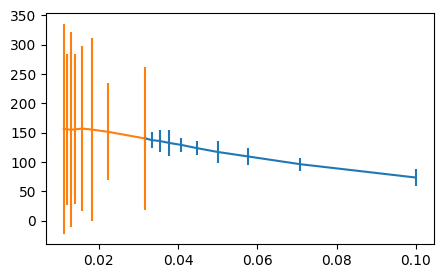

In [132]:
plt.errorbar(sqrt_pairing['diff'], list(map(lambda x: x[0], sqrt_pairing['mean'])), 
         yerr=list(map(lambda x: x[0,0], sqrt_pairing['cov'])))
plt.errorbar(sqrt_pairing_small['diff'], list(map(lambda x: x[0], sqrt_pairing_small['mean'])), 
            yerr=list(map(lambda x: x[0,0], sqrt_pairing_small['cov'])))

Ok, so it's possible that the means are converging as $d\theta$ gets smaller, but the error bars are too large to be able to tell. We need to use the 10 baseline to get good results.

#### To run these large numbers of samples, we might need to improve the efficiency.


In [149]:
N = 1000
img = generateGrating(N*[angle+diff], pixelDim=pixelDim,shotNoise=shotNoise, noiseVar=noiseVar)

print(img.shape, img.dtype)

torch.Size([1000, 101, 101]) torch.float32


Calculating the memory requirements:

4 bytes * 101*101 = 40.8kb


1000 samples: 40.8 MB  
10000 samples: 408 MB


This really doesn't seem too large. Generating large tensors seems to result in a spike in memory usage much large than the raw memory requirements of the tensors themselves. This may be fixable in generation code, but I could also just run it multiple times

#### Summary
We saw above that the derivative estimates are a major source of variance in the Fisher information estimates. In sum, even small variance results in very 'jumpy' derivatives, and very large numbers of samples are required to get small variance. For finite differences, the variance scales quadratically in the step size, but only linearly in the number of samples.

## Covariance estimate

How much noise do the covariance estimates introduce into the Fisher information measurements?


In [31]:
N = 1000
angle=0.

def make_cov_samples(Ns, angle=angle, reps=100):
    samples = []
    N_out = []d
    
    for N in Ns:
        for rep in range(reps):
            centered = trained_model.forward(generateGrating(N*[angle], pixelDim=pixelDim,
                                         shotNoise=shotNoise, noiseVar=noiseVar)).detach()

            samples.append(torch.cov(centered.T).numpy())
            N_out.append(N)

        print(N)
    
    return pd.DataFrame({'N': N_out, 'covs': samples})
    

In [32]:
cov_samples = make_cov_samples([1000, 2000, 5000])

1000
2000
5000


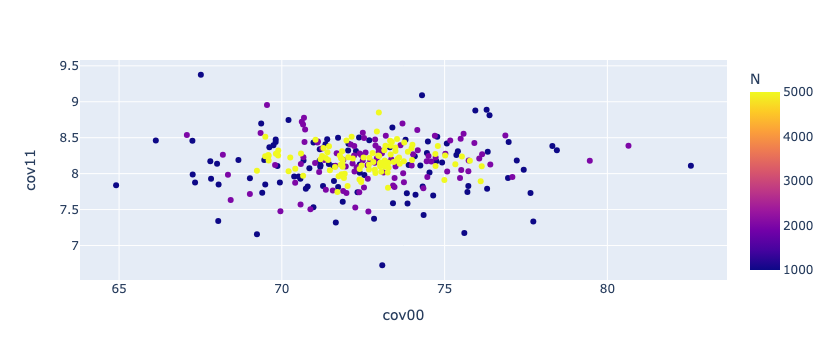

In [46]:
cov_samples['cov00'] = cov_samples['covs'].map( lambda x: x[0,0])
cov_samples['cov11'] = cov_samples['covs'].map( lambda x: x[1,1])
cov_samples['cov01'] = cov_samples['covs'].map( lambda x: x[0,1])
cov_samples['det'] = cov_samples['covs'].map(lambda x: np.linalg.det(x))

px.scatter( cov_samples, x='cov00', y='cov11', color='N')

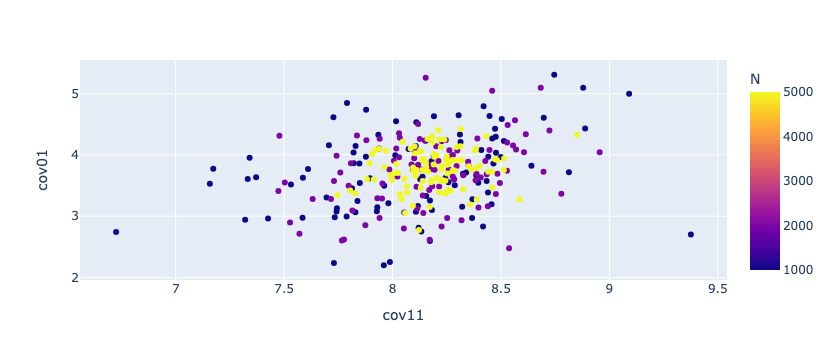

In [43]:
px.scatter( cov_samples, x='cov11', y='cov01', color='N')

In [54]:
cov_samples['det'].min()

483.1071

These covariances are relatively consistent. As expected, the estimates of the covariance become more concentrated as the number of samples increases. Additionally, note that the determinant is very large for all of the samples. The inverse of this 2x2 matrix is scaled by 
$\frac{1}{\det(A)}$
so its variance (across samples) will be shrunk by this factor squared, and thus will be very small.

Thus, this example case indicates that the (inverse) covariance estimation is not a large source of variance.



In [55]:
cov_samples_diag = make_cov_samples([1000, 2000, 5000], angle=np.pi/8 )

1000
2000
5000


In [58]:
cov_samples_diag['cov00'] = cov_samples_diag['covs'].map( lambda x: x[0,0])
cov_samples_diag['cov11'] = cov_samples_diag['covs'].map( lambda x: x[1,1])
cov_samples_diag['cov01'] = cov_samples_diag['covs'].map( lambda x: x[0,1])
cov_samples_diag['det'] = cov_samples_diag['covs'].map(lambda x: np.linalg.det(x))

In [60]:
cov_samples_diag['det'].min()

655.2326

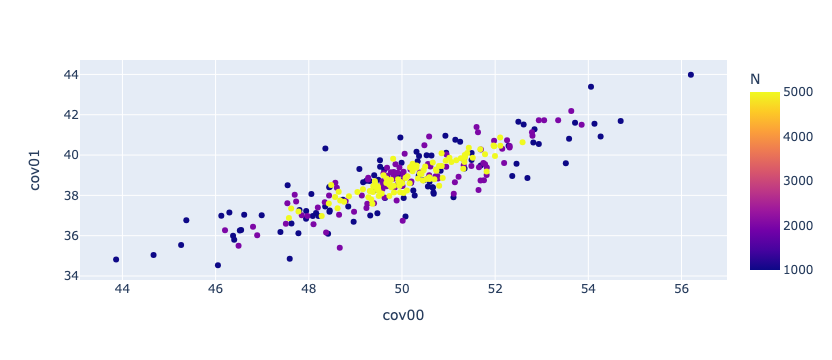

In [62]:
px.scatter( cov_samples_diag, x='cov00', y='cov01', color='N')

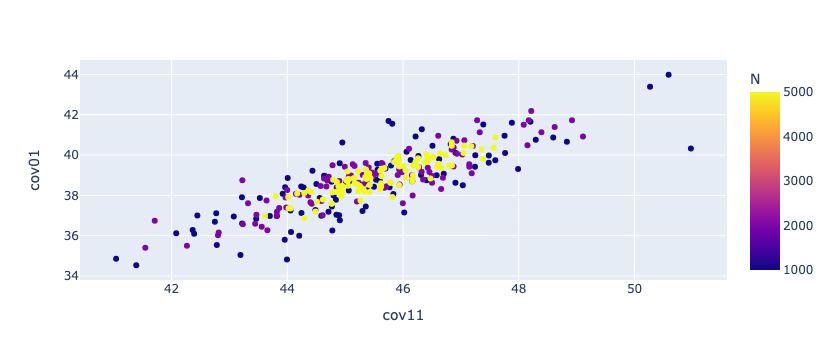

In [63]:
px.scatter( cov_samples_diag, x='cov11', y='cov01', color='N')

The covariance matrix is more diagonal here. The determinant is still large

On a cursory exploration, the covariance seems reasonably well behaved, with large determinant, in most places. The smallest determinant that I saw in my fiddling was ~280. 

#### Stationarity of the covariance matrix.

I would like to assume that the covariance is stationary for my Fisher information measurements. How much does it change between close by points?

In [160]:
def offset_samples(angle=0, offset=0.05, reps=100):
    samples_covs = []
    samples_type = []
    N=2000

    for rep in range(reps):
        centered = trained_model.forward(generateGrating(N*[angle], pixelDim=pixelDim,
                                         shotNoise=shotNoise, noiseVar=noiseVar)).detach().numpy()
        
        samples_covs.append(np.cov(centered.T))
        samples_type.append('centered')


        angled = trained_model.forward(generateGrating(N*[angle+offset], pixelDim=pixelDim,
                                       shotNoise=shotNoise, noiseVar=noiseVar)).detach().numpy()

        samples_covs.append(np.cov(angled.T))
        samples_type.append('offset')

        if rep%5 == 0:
            print(rep)


    return pd.DataFrame({'type': samples_type, 'cov': samples_covs})



In [161]:
cov_changes = offset_samples()

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [171]:
cov_changes['cov00'] = cov_changes['cov'].map( lambda x: x[0,0])
cov_changes['cov11'] = cov_changes['cov'].map( lambda x: x[1,1])
cov_changes['cov01'] = cov_changes['cov'].map( lambda x: x[0,1])

cov_changes['type'] = cov_changes['type'].astype('category')

/usr/local/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



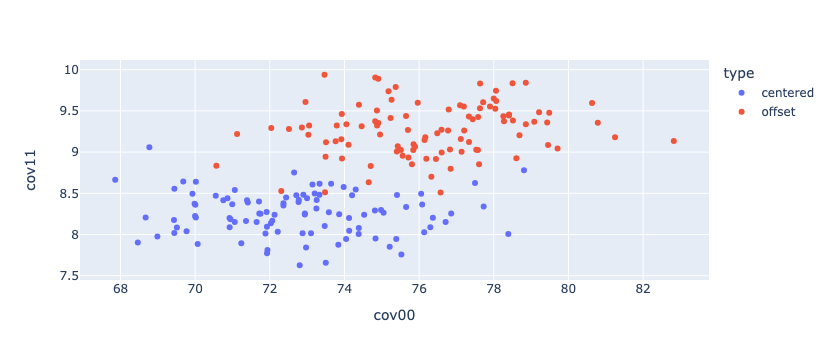

In [174]:
px.scatter(cov_changes, x='cov00', y='cov11', color='type')

/usr/local/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



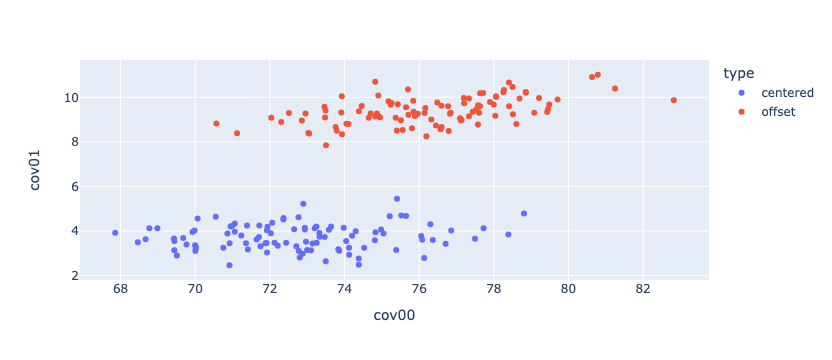

In [175]:
px.scatter(cov_changes, x='cov00', y='cov01', color='type')

Ok. Here we see clear differences in all entries of the covariance matrices for an angular difference of 0.05.
The effect on the off diagonal terms is particularly strong. 

This indicates to me that there _may well_ be an effect due to changing covariance between neurons on the information in the neural code.

In [178]:
cov_changes['inv00'] = cov_changes['cov'].map(lambda x: np.linalg.inv(x)[0,0] )
cov_changes['inv11'] = cov_changes['cov'].map(lambda x: np.linalg.inv(x)[1,1] )
cov_changes['inv01'] = cov_changes['cov'].map(lambda x: np.linalg.inv(x)[0,1] )

/usr/local/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



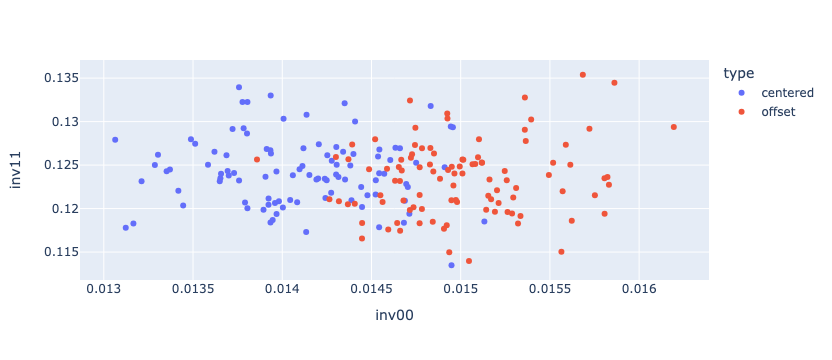

In [180]:
px.scatter(cov_changes, x='inv00', y='inv11', color='type')

/usr/local/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



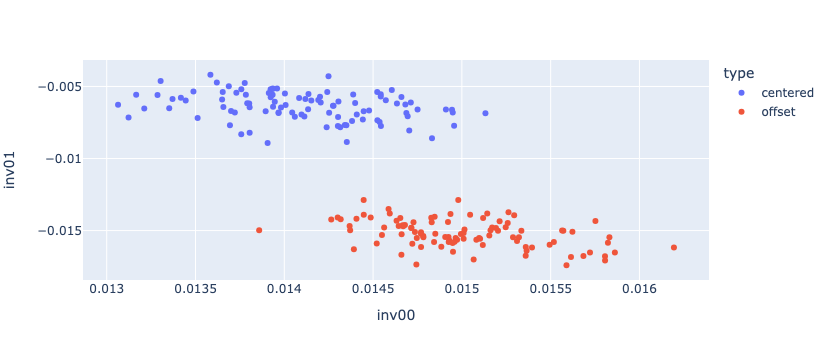

In [181]:
px.scatter(cov_changes, x='inv00', y='inv01', color='type')

The differences are smaller in magnitude for the inverse, but equally pronounced.

This means that, while improving derivative evaluation is still the top priority, the impact of changing covariance is a close second.

### Decoding approach

An alternative approach to measure the local (linear) Fisher information is by training a linear decoder, and using its discrimination performance.

We should perform both of these and compare the results.

In [232]:
def generate_train_response(mid_point, dtheta, N=1000):
    to_sample = np.linspace(mid_point-dtheta, mid_point+dtheta, N)

    samples = trained_model.forward(generateGrating(to_sample, pixelDim=pixelDim,
                                         shotNoise=shotNoise, noiseVar=noiseVar)
                                   ).detach().numpy()

    
    return pd.DataFrame( {'stimulus':to_sample, 'r1':samples[:,0], 'r2':samples[:,1]} )


def generate_test_response(mid_point, dtheta, N=500):
    to_sample = N*[mid_point - dtheta/2] + N*[mid_point + dtheta/2]

    samples = trained_model.forward(generateGrating(to_sample, pixelDim=pixelDim,
                                         shotNoise=shotNoise, noiseVar=noiseVar)
                                   ).detach().numpy()

    return pd.DataFrame( {'stimulus':to_sample, 'r1':samples[:,0], 'r2':samples[:,1]} )


In [211]:
response_data = generate_train_stimuli(0, 0.1)

In [212]:
import statsmodels.formula.api as smf

In [213]:
local_linear = smf.ols('stimulus ~ r1 + r2', data=response_data)
local_linear = local_linear.fit()

In [214]:
test = generate_test_stimuli(0., 0.1)

In [220]:
o1 = local_linear.predict(test)[0:500]
o2 = local_linear.predict(test)[500:]

In [228]:
((o1.mean() - o2.mean())/0.1)**2 / (0.5*(o1.var() + o2.var() ))

7579.671663870292

Nicely, this looks relatively consistent with the (quite noisy) result obtained from the direct evaluation approach.

In [251]:
def Fisher_info_discrimination(theta, dtheta=0.05, N=1000):
    train_resp = generate_train_response(theta, dtheta, N)
    lin = smf.ols('stimulus ~ r1 + r2', data=train_resp)
    lin = lin.fit()

    test_resp = generate_test_response(theta, dtheta, N//2)
    o1 = lin.predict(test_resp[0:N//2])
    o2 = lin.predict(test_resp[N//2:])
    
    return ((o1.mean() - o2.mean())/0.1)**2 / (0.5*(o1.var() + o2.var() ))

In [252]:
s = []
for i in range(100):
    s.append( Fisher_info_discrimination(0, 0.1) )
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(array([ 1.,  5., 10., 13., 16., 20., 12.,  9., 10.,  4.]),
 array([6771.33508584, 6927.03435867, 7082.73363151, 7238.43290434,
        7394.13217718, 7549.83145001, 7705.53072284, 7861.22999568,
        8016.92926851, 8172.62854134, 8328.32781418]),
 <BarContainer object of 10 artists>)

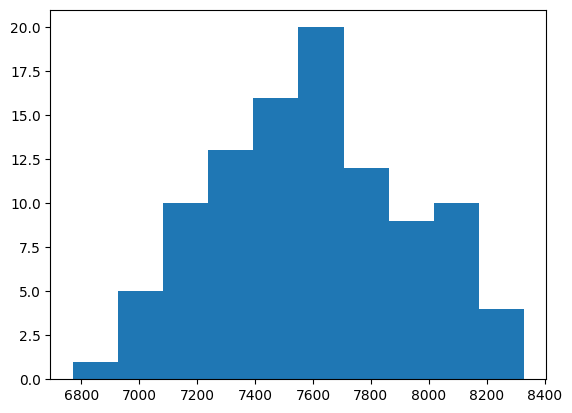

In [253]:
plt.hist(s)

Yeah so, this doesn't seem much less noisy than other approaches.

In [254]:
s = []
for i in range(100):
    s.append( Fisher_info_discrimination(0, 0.1, N=5000) )
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


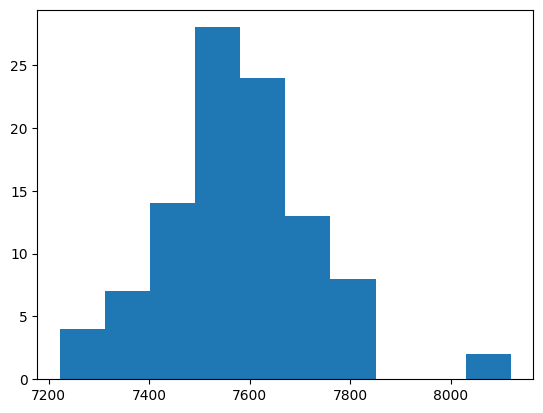

In [255]:
_=plt.hist(s)

More samples does tighten up the estimates, but the effect is not as large as I would like considering that this is 5 times more samples.

In [ ]:
def Fisher_info_discrimination(theta, dtheta=0.05, N=1000):
    train_resp = generate_test_response(theta, dtheta, N)
    lin = smf.ols('stimulus ~ r1 + r2', data=train_resp)
    lin = lin.fit()

    test_resp = generate_test_response(theta, dtheta, N//2)
    o1 = lin.predict(test_resp[0:N//2])
    o2 = lin.predict(test_resp[N//2:])
    
    return ((o1.mean() - o2.mean())/0.1)**2 / (0.5*(o1.var() + o2.var() ))

s = []
for i in range(100):
    s.append( Fisher_info_discrimination(0, 0.1, N=1000) )
    print(i)

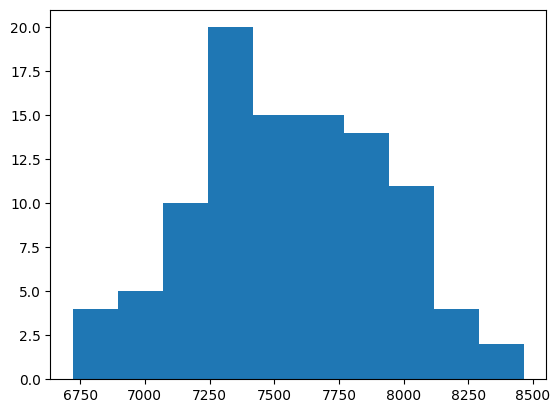

In [259]:
_=plt.hist(s)

We can also change how stimuli are sampled during training, but this doesn't seem to have much effect.